In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime as dt
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import KFold


In [2]:
!pip install openpyxl

In [3]:
flight=pd.read_excel('Data_Train.xlsx')
flight.head(3)

Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882

## Shape of the Dataset

In [4]:
flight.shape

(10683, 11)

## Checking Column Datatype

In [5]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


#### 
- Here `Date_of_journey` Column is not correct Datatypes
- `Route` and `Total_stops` Column has 1 `Nan` Value

## Check The Summary of Each Column

In [6]:
flight.describe()

Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000

In [7]:
flight.describe(include=['object'])

Airline Date_of_Journey Source Destination            Route  \
count         10683           10683  10683       10683            10682   
unique           12              44      5           6              128   
top     Jet Airways      18/05/2019  Delhi      Cochin  DEL → BOM → COK   
freq           3849             504   4537        4537             2376   

       Dep_Time Arrival_Time Duration Total_Stops Additional_Info  
count     10683        10683    10683       10682           10683  
unique      222         1343      368           5              10  
top       18:55        19:00   2h 50m      1 stop         No info  
freq        233          423      550        5625            8345

## Checking For Missing Value

In [8]:
flight.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
px.density_heatmap(data_frame=flight.isna().sum())

In [10]:
flight=flight.dropna()

## Data  Cleaning

In [11]:
## Changing Date of Journey column Datatype 
flight['Date_of_Journey']=pd.to_datetime(flight['Date_of_Journey'])

In [12]:
## only taking arrival time ie hr:min some of values are '12:56 10 Mar'
pattern='\d{2}:\d{2}'
flight['Arrival_Time']=flight['Arrival_Time'].apply(lambda x:re.findall(pattern,x)[0])

In [13]:
flight.head(2)

Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-01-05   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20        01:10   2h 50m    non-stop         No info   3897  
1    05:50        13:15   7h 25m     2 stops         No info   7662

- In `Duration` Column Adding 00m Where only Hr is given
- After that we Calualate total duration in minutes

In [14]:
pattern='\d{1,2}\w\s\d{2}\w'

In [15]:
Time=[]
for time in flight['Duration']:
    if re.findall(pattern,time):
        Time.append(time)    
    else:
        time=time+' '+'00m'
        Time.append(time)
      

In [16]:
flight['Duration']=Time

In [17]:

hour=flight['Duration'].apply(lambda x:x.split(' ')[0][:-1]).astype('int')
minute=flight['Duration'].apply(lambda x:x.split(' ')[1][:-1]).astype('int')
flight['Duration']=hour*60+minute

In [18]:
flight.head(2)

Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-01-05   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time Arrival_Time  Duration Total_Stops Additional_Info  Price  
0    22:20        01:10       170    non-stop         No info   3897  
1    05:50        13:15       445     2 stops         No info   7662

## Extract the Date , Month ,week from Date_of_Journey

In [19]:
flight['week']=flight['Date_of_Journey'].dt.week
flight['Day_name']=flight['Date_of_Journey'].dt.day_name()
flight['month_name']=flight['Date_of_Journey'].dt.month_name()
flight['month']=flight['Date_of_Journey'].dt.month
flight['Day']=flight['Date_of_Journey'].dt.day


<ipython-input-19-4559ce71e021>:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [20]:
flight.head(2)

Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-01-05   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time Arrival_Time  Duration Total_Stops Additional_Info  Price  week  \
0    22:20        01:10       170    non-stop         No info   3897    12   
1    05:50        13:15       445     2 stops         No info   7662     1   

   Day_name month_name  month  Day  
0    Sunday      March      3   24  
1  Saturday    January      1    5

In [21]:
flight.drop('Date_of_Journey',axis=1,inplace=True)

In [22]:
flight.head(2)

Airline    Source Destination                  Route Dep_Time  \
0     IndiGo  Banglore   New Delhi              BLR → DEL    22:20   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR    05:50   

  Arrival_Time  Duration Total_Stops Additional_Info  Price  week  Day_name  \
0        01:10       170    non-stop         No info   3897    12    Sunday   
1        13:15       445     2 stops         No info   7662     1  Saturday   

  month_name  month  Day  
0      March      3   24  
1    January      1    5

## Exploratory Data Analysis

In [23]:
def unvairate(data,col):
    df=data[col].value_counts(normalize=True).reset_index()
    fig=px.pie(names=df['index'],values=df[col])
    fig.show()
    
def bivariate(data,col):
    fig=px.bar(data_frame=data,x=col,y='Price',color=col)
    fig.update_traces(dict(marker_line_width=0))
    fig.show()


In [24]:
unvairate(flight,'Airline')
bivariate(flight,'Airline')

- People use Jet Airways more than the other Airline.
- Jetways Airline is also expensive among all.

In [25]:
unvairate(flight,'Source')
bivariate(flight,'Source')

- 42.5% flights starts from Delhi.
- In Price also It is high 

In [26]:
unvairate(flight,'Destination')
bivariate(flight,'Destination')

- As we see More number People prefer to Go to Kochin,Banglore than other states.

In [27]:
unvairate(flight,'Total_Stops')
bivariate(flight,'Total_Stops')


- Flight Which have 1 Stops has higher in Price

In [28]:
unvairate(flight,'month_name')
bivariate(flight,'month_name')

- In  Month of June ,May ,March Prices More.

In [29]:
unvairate(flight,'Day_name')
bivariate(flight,'Day_name')

- Prices are More on Thursday in comparion to other days while friday and Monday have high Price.

In [30]:
unvairate(flight,'week')
bivariate(flight,'week')

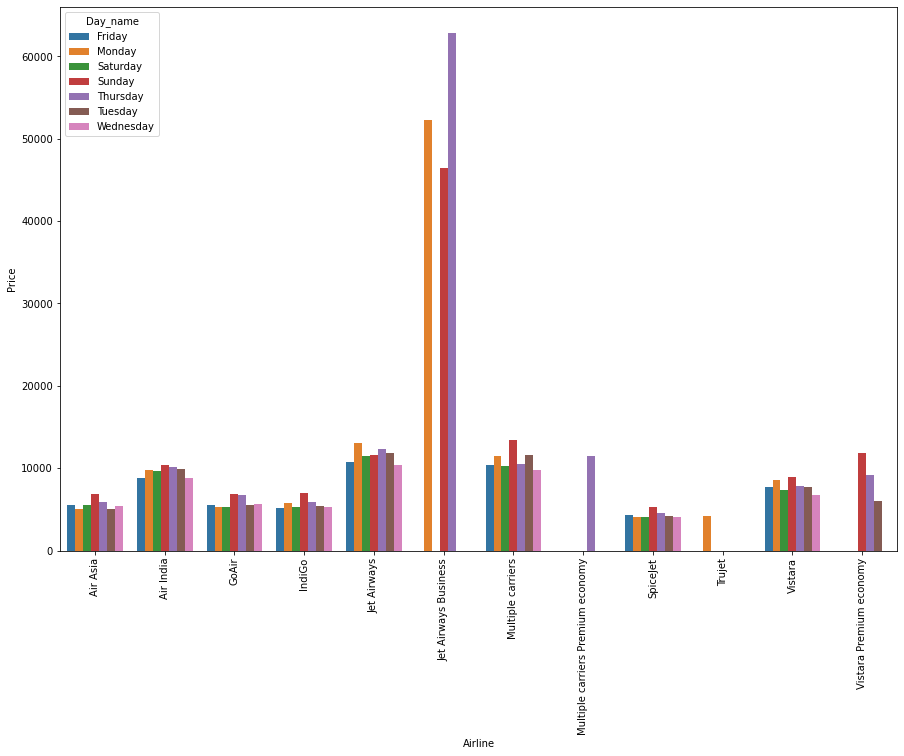

In [31]:
Airline_Day_name=(flight.groupby(['Airline','Day_name'])['Price'].mean().reset_index())
plt.figure(figsize=(15,10))
sns.barplot(data=Airline_Day_name,x='Airline',y='Price',hue='Day_name')
plt.xticks(rotation=90)
plt.show()

- Jet Airways Bussiness Class has highest Price among all the other flighs 

In [32]:
(flight.drop(['Day_name','month_name','week'],1,inplace=True))

In [33]:
## creating new col from dep_time .
flight['Dep_hour']=(flight['Dep_Time'].apply(lambda x:x.split(':')[0])).astype('int')
flight['Dep_min']=(flight['Dep_Time'].apply(lambda x:x.split(':')[1])).astype('int')

In [34]:
## creating new col from arrival_time
flight['Arrival_hour']=(flight['Arrival_Time'].apply(lambda x:x.split(':')[0])).astype('int')
flight['Arrival_min']=(flight['Arrival_Time'].apply(lambda x:x.split(':')[1])).astype('int')

In [35]:
flight.drop(['Arrival_Time','Dep_Time'],1,inplace=True)

In [36]:
flight['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [37]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys
flight['Total_Stops']=flight['Total_Stops'].replace({"1 stop":1,'non-stop':0,'2 stops':2,'3 stops':3,'4 stops':3})

In [38]:
flight['Total_Stops'].value_counts()

1    5625
0    3491
2    1520
3      46
Name: Total_Stops, dtype: int64

In [39]:
flight['Additional_Info'].value_counts(normalize=True)

No info                         0.781127
In-flight meal not included     0.185546
No check-in baggage included    0.029957
1 Long layover                  0.001779
Change airports                 0.000655
Business class                  0.000374
No Info                         0.000281
Red-eye flight                  0.000094
2 Long layover                  0.000094
1 Short layover                 0.000094
Name: Additional_Info, dtype: float64

- In This feature doesnt add information to the Predicted varibale so we remove it 

In [40]:
# Additional_Info contains almost 80% no_info
flight.drop(['Additional_Info'],1,inplace=True)

- Route Columns and Total_stops Convey the same information So we remove Route col from it.

In [41]:
flight

Airline    Source Destination                  Route  Duration  \
0           IndiGo  Banglore   New Delhi              BLR → DEL       170   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR       445   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK      1140   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR       325   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL       285   
...            ...       ...         ...                    ...       ...   
10678     Air Asia   Kolkata    Banglore              CCU → BLR       150   
10679    Air India   Kolkata    Banglore              CCU → BLR       155   
10680  Jet Airways  Banglore       Delhi              BLR → DEL       180   
10681      Vistara  Banglore   New Delhi              BLR → DEL       160   
10682    Air India     Delhi      Cochin  DEL → GOI → BOM → COK       500   

       Total_Stops  Price  month  Day  Dep_hour  Dep_min  Arrival_hour  \
0                0   3897      3   24        22       20             1   
1                2   7662      1    5         5       50            13   
2                2  13882      9    6         9       25             4   
3                1   6218     12    5        18        5            23   
4                1  13302      1    3        16       50            21   
...            ...    ...    ...  ...       ...      ...           ...   
10678            0   4107      9    4        19       55            22   
10679            0   4145      4   27        20       45            23   
10680            0   7229      4   27         8       20            11   
10681            0  12648      1    3        11       30            14   
10682            2  11753      9    5        10       55            19   

       Arrival_min  
0               10  
1               15  
2               25  
3               30  
4               35  
...            ...  
10678           25  
10679           20  
10680           20  
10681           10  
10682           15  

[10682 rows x 13 columns]

In [42]:
flight['Destination']=(flight['Destination'].replace({'New Delhi':'Delhi'}))

In [43]:
flight['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [44]:
## dropping the Route col from dataset
flight.drop(['Route'],1,inplace=True)

In [45]:
flight.head()

Airline    Source Destination  Duration  Total_Stops  Price  month  \
0       IndiGo  Banglore       Delhi       170            0   3897      3   
1    Air India   Kolkata    Banglore       445            2   7662      1   
2  Jet Airways     Delhi      Cochin      1140            2  13882      9   
3       IndiGo   Kolkata    Banglore       325            1   6218     12   
4       IndiGo  Banglore       Delhi       285            1  13302      1   

   Day  Dep_hour  Dep_min  Arrival_hour  Arrival_min  
0   24        22       20             1           10  
1    5         5       50            13           15  
2    6         9       25             4           25  
3    5        18        5            23           30  
4    3        16       50            21           35

In [46]:
## # As Source is Nominal Categorical data we will perform OneHotEncoding
source=pd.get_dummies(flight[['Source']],drop_first=True)
# As Destination is Nominal Categorical data we will perform OneHotEncoding
destination=pd.get_dummies(flight[['Destination']],drop_first=True)
# As Airline is Nominal Categorical data we will perform OneHotEncoding
airline=pd.get_dummies(flight[['Airline']],drop_first=True)


In [47]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([flight, airline, source, destination], axis = 1)

In [48]:
data_train.head(2)

Airline    Source Destination  Duration  Total_Stops  Price  month  Day  \
0     IndiGo  Banglore       Delhi       170            0   3897      3   24   
1  Air India   Kolkata    Banglore       445            2   7662      1    5   

   Dep_hour  Dep_min  ...  Airline_Vistara  Airline_Vistara Premium economy  \
0        22       20  ...                0                                0   
1         5       50  ...                0                                0   

   Source_Chennai  Source_Delhi  Source_Kolkata  Source_Mumbai  \
0               0             0               0              0   
1               0             0               1              0   

   Destination_Cochin  Destination_Delhi  Destination_Hyderabad  \
0                   0                  1                      0   
1                   0                  0                      0   

   Destination_Kolkata  
0                    0  
1                    0  

[2 rows x 31 columns]

In [49]:
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [50]:
test_set=pd.read_excel('Test_set.xlsx')
test_set.head(2)

Airline Date_of_Journey   Source Destination            Route Dep_Time  \
0  Jet Airways       6/06/2019    Delhi      Cochin  DEL → BOM → COK    17:30   
1       IndiGo      12/05/2019  Kolkata    Banglore  CCU → MAA → BLR    06:20   

   Arrival_Time Duration Total_Stops Additional_Info  
0  04:25 07 Jun  10h 55m      1 stop         No info  
1         10:20       4h      1 stop         No info

In [51]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [52]:
test_set.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [53]:
## Check for Outiler
data_train['Price'].describe([.75,.90,.95,.99])

count    10682.000000
mean      9087.214567
std       4611.548810
min       1759.000000
50%       8372.000000
75%      12373.000000
90%      14714.000000
95%      15764.000000
99%      22270.000000
max      79512.000000
Name: Price, dtype: float64

In [54]:
px.histogram(data_train['Price'],marginal="box")

- Price Columns Has Outiler so we remove or it replace it median value

In [55]:
# calculate Q1 and Q3
Q1 = data_train['Price'].quantile(0.25)
Q3 = data_train['Price'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# filter the dataset with the IQR
IQR_outliers = data_train[((data_train < (Q1 - 1.5 * IQR)) |(data_train > (Q3 + 1.5 * IQR))).any(axis=1)]
IQR_outliers

Duration  Total_Stops  Price  month  Day  Dep_hour  Dep_min  \
123        1215            1  27430      1    3        23        0   
396         385            1  36983      1    3        12       50   
486         380            1  26890      1    3         8       55   
510         325            1  26890      1    3         7        0   
597        1775            2  25139      6    3         9       40   
...         ...          ...    ...    ...  ...       ...      ...   
10353      1260            2  24210      6    3        19       50   
10364       280            1  57209      1    3         9       45   
10383      1325            1  26890      1    3         7        0   
10439       860            1  31825      1    3        18       40   
10511      1600            2  26480      1    3         6       45   

       Arrival_hour  Arrival_min  Airline_Air India  ...  Airline_Vistara  \
123              19           15                  1  ...                0   
396              19           15                  0  ...                0   
486              15           15                  0  ...                0   
510              12           25                  0  ...                0   
597              15           15                  1  ...                0   
...             ...          ...                ...  ...              ...   
10353            16           50                  0  ...                0   
10364            14           25                  0  ...                0   
10383             5            5                  0  ...                0   
10439             9            0                  0  ...                0   
10511             9           25                  1  ...                0   

       Airline_Vistara Premium economy  Source_Chennai  Source_Delhi  \
123                                  0               0             1   
396                                  0               0             1   
486                                  0               0             0   
510                                  0               0             0   
597                                  0               0             0   
...                                ...             ...           ...   
10353                                0               0             0   
10364                                0               0             0   
10383                                0               0             0   
10439                                0               0             0   
10511                                0               0             0   

       Source_Kolkata  Source_Mumbai  Destination_Cochin  Destination_Delhi  \
123                 0              0                   1                  0   
396                 0              0                   1                  0   
486                 0              0                   0                  1   
510                 0              0                   0                  1   
597                 0              1                   0                  0   
...               ...            ...                 ...                ...   
10353               0              1                   0                  0   
10364               0              0                   0                  1   
10383               0              0                   0                  1   
10439               0              0                   0                  1   
10511               0              0                   0                  1   

       Destination_Hyderabad  Destination_Kolkata  
123                        0                    0  
396                        0                    0  
486                        0                    0  
510                        0                    0  
597                        1                    0  
...                      ...                  ...  
10353                      1                    0  
10364      

In [56]:
data_train = data_train[~((data_train < (Q1 - 1.5 * IQR)) |(data_train > (Q3 + 1.5 * IQR))).any(axis=1)]

In [57]:
data_train

Duration  Total_Stops  Price  month  Day  Dep_hour  Dep_min  \
0           170            0   3897      3   24        22       20   
1           445            2   7662      1    5         5       50   
2          1140            2  13882      9    6         9       25   
3           325            1   6218     12    5        18        5   
4           285            1  13302      1    3        16       50   
...         ...          ...    ...    ...  ...       ...      ...   
10678       150            0   4107      9    4        19       55   
10679       155            0   4145      4   27        20       45   
10680       180            0   7229      4   27         8       20   
10681       160            0  12648      1    3        11       30   
10682       500            2  11753      9    5        10       55   

       Arrival_hour  Arrival_min  Airline_Air India  ...  Airline_Vistara  \
0                 1           10                  0  ...                0   
1                13           15                  1  ...                0   
2                 4           25                  0  ...                0   
3                23           30                  0  ...                0   
4                21           35                  0  ...                0   
...             ...          ...                ...  ...              ...   
10678            22           25                  0  ...                0   
10679            23           20                  1  ...                0   
10680            11           20                  0  ...                0   
10681            14           10                  0  ...                1   
10682            19           15                  1  ...                0   

       Airline_Vistara Premium economy  Source_Chennai  Source_Delhi  \
0                                    0               0             0   
1                                    0               0             0   
2                                    0               0             1   
3                                    0               0             0   
4                                    0               0             0   
...                                ...             ...           ...   
10678                                0               0             0   
10679                                0               0             0   
10680                                0               0             0   
10681                                0               0             0   
10682                                0               0             1   

       Source_Kolkata  Source_Mumbai  Destination_Cochin  Destination_Delhi  \
0                   0              0                   0                  1   
1                   1              0                   0                  0   
2                   0              0                   1                  0   
3                   1              0                   0                  0   
4                   0              0                   0                  1   
...               ...            ...                 ...                ...   
10678               1              0                   0                  0   
10679               1              0                   0                  0   
10680               0              0                   0                  1   
10681               0              0                   0                  1   
10682               0              0                   1                  0   

       Destination_Hyderabad  Destination_Kolkata  
0                          0                    0  
1                          0                    0  
2                          0                    0  
3                          0                    0  
4                          0                    0  
...                      ...                  ...  
10678                      0                    0  
10679      

In [58]:
px.histogram(data_train['Price'],marginal="box")

<AxesSubplot:>

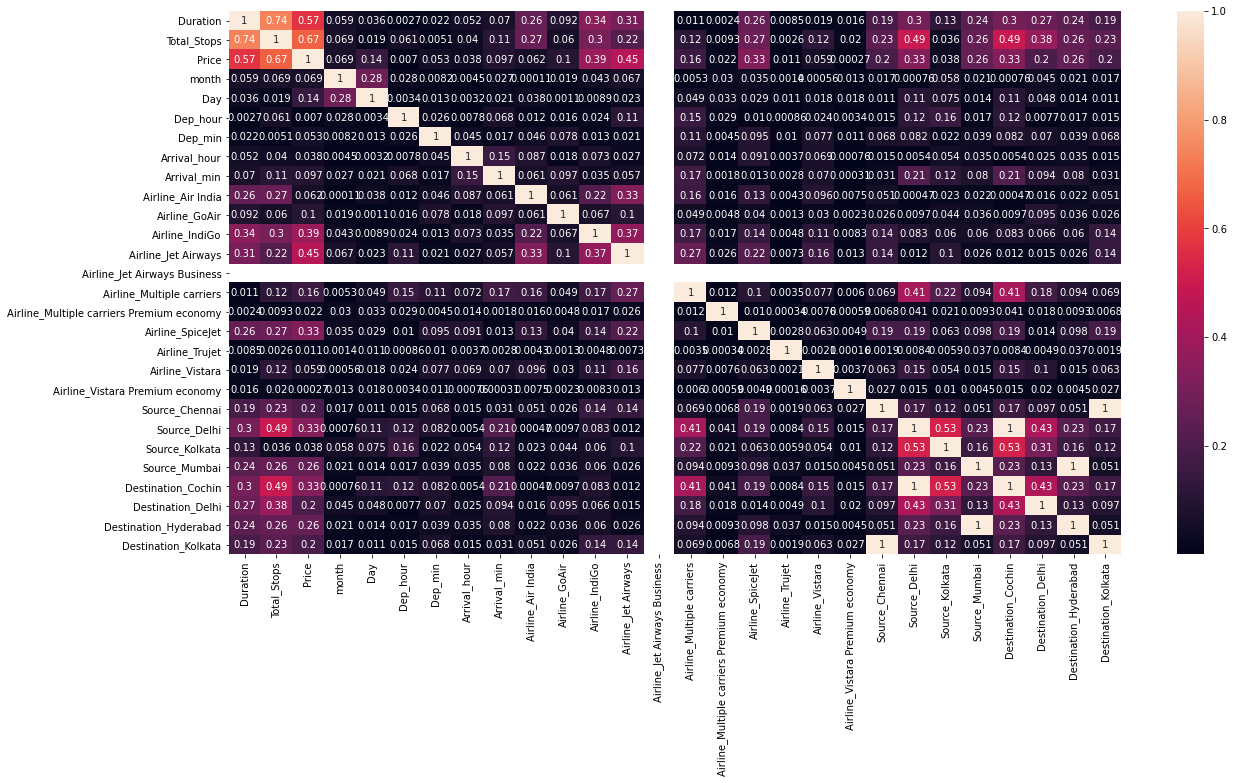

In [59]:
# full correlation table
plt.figure(figsize=(20,10))
sns.heatmap(data_train.corr().abs(),annot=True)

- Total Stops and Duration are the coulmns which are mainly increasing the price or decreasing it .

In [60]:
def test_set_preprocessing(test_set):
## Changing Date of Journey column Datatype 
    test_set['Date_of_Journey']=pd.to_datetime(test_set['Date_of_Journey'])
    ## only taking arrival time ie hr:min some of values are '12:56 10 Mar'
    pattern='\d{2}:\d{2}'
    test_set['Arrival_Time']=test_set['Arrival_Time'].apply(lambda x:re.findall(pattern,x)[0])
    ## In Duration Column Adding 00m Where only Hr is given
    ## After that we Calualate total duration in minutes
    pattern='\d{1,2}\w\s\d{2}\w'
    Time=[]
    for time in test_set['Duration']:
        if re.findall(pattern,time):
            Time.append(time)    
        else:
            time=time+' '+'00m'
            Time.append(time)
    test_set['Duration']=Time
    hour=test_set['Duration'].apply(lambda x:x.split(' ')[0][:-1]).astype('int')
    minute=test_set['Duration'].apply(lambda x:x.split(' ')[1][:-1]).astype('int')
    test_set['Duration']=hour*60+minute
    ## extracting Day and month
    test_set['month']=test_set['Date_of_Journey'].dt.month
    test_set['Day']=test_set['Date_of_Journey'].dt.day
    test_set.drop('Date_of_Journey',axis=1,inplace=True)
    ## creating new col from dep_time .
    test_set['Dep_hour']=(test_set['Dep_Time'].apply(lambda x:x.split(':')[0])).astype('int')
    test_set['Dep_min']=(test_set['Dep_Time'].apply(lambda x:x.split(':')[1])).astype('int')
    ## creating new col from arrival_time
    test_set['Arrival_hour']=(test_set['Arrival_Time'].apply(lambda x:x.split(':')[0])).astype('int')
    test_set['Arrival_min']=(test_set['Arrival_Time'].apply(lambda x:x.split(':')[1])).astype('int')
    test_set.drop(['Arrival_Time','Dep_Time'],1,inplace=True)
    # As this is case of Ordinal Categorical type we perform LabelEncoder
    # Here Values are assigned with corresponding keys
    test_set['Total_Stops']=test_set['Total_Stops'].replace({"1 stop":1,'non-stop':0,'2 stops':2,'3 stops':3,'4 stops':3})
    # Additional_Info contains almost 80% no_info
    test_set.drop(['Additional_Info'],1,inplace=True)
    ## dropping the Route col from dataset
    test_set.drop(['Route'],1,inplace=True)
    ## # As Source is Nominal Categorical data we will perform OneHotEncoding
    source=pd.get_dummies(test_set[['Source']],drop_first=True)
    # As Destination is Nominal Categorical data we will perform OneHotEncoding
    destination=pd.get_dummies(test_set[['Destination']],drop_first=True)
    # As Airline is Nominal Categorical data we will perform OneHotEncoding
    airline=pd.get_dummies(test_set[['Airline']],drop_first=True)
    # Concatenate dataframe --> train_data + Airline + Source + Destination
    test_set = pd.concat([test_set, airline, source, destination], axis = 1)
    ##remove the Original columns
    test_set.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)
    return test_set


In [61]:
data_train.drop('Airline_Trujet',1,inplace=True)

In [62]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10588 entries, 0 to 10682
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Duration                                   10588 non-null  int32
 1   Total_Stops                                10588 non-null  int64
 2   Price                                      10588 non-null  int64
 3   month                                      10588 non-null  int64
 4   Day                                        10588 non-null  int64
 5   Dep_hour                                   10588 non-null  int32
 6   Dep_min                                    10588 non-null  int32
 7   Arrival_hour                               10588 non-null  int32
 8   Arrival_min                                10588 non-null  int32
 9   Airline_Air India                          10588 non-null  uint8
 10  Airline_GoAir                              105

In [63]:
## Taking out the numerical columns
normalization=['Duration','Total_Stops','month','Day','Dep_hour','Dep_min','Arrival_hour','Arrival_min']

In [64]:
data_train[normalization].head()

Duration  Total_Stops  month  Day  Dep_hour  Dep_min  Arrival_hour  \
0       170            0      3   24        22       20             1   
1       445            2      1    5         5       50            13   
2      1140            2      9    6         9       25             4   
3       325            1     12    5        18        5            23   
4       285            1      1    3        16       50            21   

   Arrival_min  
0           10  
1           15  
2           25  
3           30  
4           35

In [65]:
data_train

Duration  Total_Stops  Price  month  Day  Dep_hour  Dep_min  \
0           170            0   3897      3   24        22       20   
1           445            2   7662      1    5         5       50   
2          1140            2  13882      9    6         9       25   
3           325            1   6218     12    5        18        5   
4           285            1  13302      1    3        16       50   
...         ...          ...    ...    ...  ...       ...      ...   
10678       150            0   4107      9    4        19       55   
10679       155            0   4145      4   27        20       45   
10680       180            0   7229      4   27         8       20   
10681       160            0  12648      1    3        11       30   
10682       500            2  11753      9    5        10       55   

       Arrival_hour  Arrival_min  Airline_Air India  ...  Airline_Vistara  \
0                 1           10                  0  ...                0   
1                13           15                  1  ...                0   
2                 4           25                  0  ...                0   
3                23           30                  0  ...                0   
4                21           35                  0  ...                0   
...             ...          ...                ...  ...              ...   
10678            22           25                  0  ...                0   
10679            23           20                  1  ...                0   
10680            11           20                  0  ...                0   
10681            14           10                  0  ...                1   
10682            19           15                  1  ...                0   

       Airline_Vistara Premium economy  Source_Chennai  Source_Delhi  \
0                                    0               0             0   
1                                    0               0             0   
2                                    0               0             1   
3                                    0               0             0   
4                                    0               0             0   
...                                ...             ...           ...   
10678                                0               0             0   
10679                                0               0             0   
10680                                0               0             0   
10681                                0               0             0   
10682                                0               0             1   

       Source_Kolkata  Source_Mumbai  Destination_Cochin  Destination_Delhi  \
0                   0              0                   0                  1   
1                   1              0                   0                  0   
2                   0              0                   1                  0   
3                   1              0                   0                  0   
4                   0              0                   0                  1   
...               ...            ...                 ...                ...   
10678               1              0                   0                  0   
10679               1              0                   0                  0   
10680               0              0                   0                  1   
10681               0              0                   0                  1   
10682               0              0                   1                  0   

       Destination_Hyderabad  Destination_Kolkata  
0                          0                    0  
1                          0                    0  
2                          0                    0  
3                          0                    0  
4                          0                    0  
...                      ...                  ...  
10678                      0                    0  
10679      

## Train Test Split

In [66]:
## create x and y 
y=data_train.pop('Price')
X=data_train

In [67]:
## Train Test split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=.70,random_state=2)

In [68]:
X_train

Duration  Total_Stops  month  Day  Dep_hour  Dep_min  Arrival_hour  \
5086        80            0      3   15         5       45             7   
4182        90            0      3   15        10       20            11   
833        660            1      9    4         8        0            19   
7953      1100            1      6   24        18       15            12   
8771       150            0      6   15        17       10            19   
...        ...          ...    ...  ...       ...      ...           ...   
1112        90            0      6   21        21       20            22   
2541        90            0      1    6        10       20            11   
6695       145            0      4   21         9        0            11   
2603       165            0      1    4         6        5             8   
7398       290            1      3    6        15       10            20   

      Arrival_min  Airline_Air India  Airline_GoAir  ...  Airline_Vistara  \
5086            5                  0              0  ...                0   
4182           50                  0              0  ...                0   
833             0                  0              0  ...                0   
7953           35                  0              0  ...                0   
8771           40                  0              0  ...                0   
...           ...                ...            ...  ...              ...   
1112           50                  0              0  ...                0   
2541           50                  0              0  ...                0   
6695           25                  0              0  ...                0   
2603           50                  0              0  ...                0   
7398            0                  0              0  ...                0   

      Airline_Vistara Premium economy  Source_Chennai  Source_Delhi  \
5086                                0               0             0   
4182                                0               0             0   
833                                 0               0             1   
7953                                0               0             1   
8771                                0               0             0   
...                               ...             ...           ...   
1112                                0               0             0   
2541                                0               0             0   
6695                                0               0             0   
2603                                0               0             0   
7398                                0               0             1   

      Source_Kolkata  Source_Mumbai  Destination_Cochin  Destination_Delhi  \
5086               0              1                   0                  0   
4182               0              1                   0                  0   
833                0              0                   1                  0   
7953               0              0                   1                  0   
8771               1              0                   0                  0   
...              ...            ...                 ...                ...   
1112               0              1                   0                  0   
2541               0              1                   0                  0   
6695               1              0                   0                  0   
2603               0              0                   0                  1   
7398               0              0                   1                  0   

      Destination_Hyderabad  Destination_Kolkata  
5086                      1                    0  
4182                      1                    0  
833                       0                    0  
7953                      0                    0  
8771                      0                    0  
...                     ...                  ...  
1112                 

In [69]:
## creating the object of the standard scaler
scaler=StandardScaler()
X_train[normalization]=scaler.fit_transform(X_train[normalization])
## For test set
X_test[normalization]=scaler.transform(X_test[normalization])

In [70]:
X_train

Duration  Total_Stops     month       Day  Dep_hour   Dep_min  \
5086 -1.104934    -1.212337 -0.873326  0.259486 -1.301938  1.098428   
4182 -1.085168    -1.212337 -0.873326  0.259486 -0.433550 -0.236072   
833   0.041545     0.261519  1.141164 -0.991388 -0.780905 -1.303671   
7953  0.911288     0.261519  0.133919  1.282928  0.955872 -0.502972   
8771 -0.966566    -1.212337  0.133919  0.259486  0.782194 -0.769872   
...        ...          ...       ...       ...       ...       ...   
1112 -1.085168    -1.212337  0.133919  0.941781  1.476905 -0.236072   
2541 -1.085168    -1.212337 -1.544823 -0.763957 -0.433550 -0.236072   
6695 -0.976450    -1.212337 -0.537578  0.941781 -0.607228 -1.303671   
2603 -0.936916    -1.212337 -1.544823 -0.991388 -1.128261 -1.036772   
7398 -0.689830     0.261519 -0.873326 -0.763957  0.434839 -0.769872   

      Arrival_hour  Arrival_min  Airline_Air India  Airline_GoAir  ...  \
5086     -0.920931    -1.196828                  0              0  ...   
4182     -0.338666     1.541765                  0              0  ...   
833       0.825865    -1.501117                  0              0  ...   
7953     -0.193100     0.628900                  0              0  ...   
8771      0.825865     0.933189                  0              0  ...   
...            ...          ...                ...            ...  ...   
1112      1.262563     1.541765                  0              0  ...   
2541     -0.338666     1.541765                  0              0  ...   
6695     -0.338666     0.020324                  0              0  ...   
2603     -0.775365     1.541765                  0              0  ...   
7398      0.971431    -1.501117                  0              0  ...   

      Airline_Vistara  Airline_Vistara Premium economy  Source_Chennai  \
5086                0                                0               0   
4182                0                                0               0   
833                 0                                0               0   
7953                0                                0               0   
8771                0                                0               0   
...               ...                              ...             ...   
1112                0                                0               0   
2541                0                                0               0   
6695                0                                0               0   
2603                0                                0               0   
7398                0                                0               0   

      Source_Delhi  Source_Kolkata  Source_Mumbai  Destination_Cochin  \
5086             0               0              1                   0   
4182             0               0              1                   0   
833              1               0              0                   1   
7953             1               0              0                   1   
8771             0               1              0                   0   
...            ...             ...            ...                 ...   
1112             0               0              1                   0   
2541             0               0              1                   0   
6695             0               1              0                   0   
2603             0               0              0                   0   
7398             1               0              0                   1   

      Destination_Delhi  Destination_Hyderabad  Destination_Kolkata  
5086                  0                      1                    0  
4182                  0                      1                    0  
833                   0                      0                    0  
7953                  0                      0                    0  
8771                  0                      0                    0  
...                 ...                    ...                  ...  
1112    

In [71]:
## creating to store model Predictioon
d={'Model_Name':[],'r2_score_on_trainSet':[],'r2_score_on_testSet':[],'mean_square_trainSet':[],'mean_square_testSet':[]}

## Model Building

In [72]:
def Model(model):
    model1=model[0]
    model1.fit(X_train,y_train)
    y_train_pred=model1.predict(X_train)
    y_test_pred=model1.predict(X_test)
    d['Model_Name'].append(model[1])
    d['r2_score_on_trainSet'].append(r2_score(y_train,y_train_pred))
    d['r2_score_on_testSet'].append(r2_score(y_test,y_test_pred))
    d['mean_square_trainSet'].append((mean_squared_error(y_train,y_train_pred)).round(2))
    d['mean_square_testSet'].append((mean_squared_error(y_test,y_test_pred)).round(2))  
    return d

In [73]:
## Taking all the model
models=[(LinearRegression(),'Linear Regression'),(RandomForestRegressor(),'RandomForest'),(DecisionTreeRegressor(),'descisionTree'),(KNeighborsRegressor(),'KNN'),(AdaBoostRegressor(),'AdaBoost'),(GradientBoostingRegressor(),'GBR'),(XGBRegressor(),'XGB')]
for model in models:
    k=Model(model)
df=pd.DataFrame(k)
df
    

Model_Name  r2_score_on_trainSet  r2_score_on_testSet  \
0  Linear Regression              0.626778             0.628788   
1       RandomForest              0.951742             0.823004   
2      descisionTree              0.965615             0.713718   
3                KNN              0.811231             0.707993   
4           AdaBoost              0.603167             0.580318   
5                GBR              0.791528             0.782990   
6                XGB              0.928177             0.852523   

   mean_square_trainSet  mean_square_testSet  
0            6244619.11           5983691.77  
1             807435.64           2853062.68  
2             575311.29           4614687.98  
3            3158415.63           4706959.15  
4            6639665.41           6765003.53  
5            3488086.92           3498061.42  
6            1201717.30           2377231.78

## Using Hyperparameter Tunning by RandomGridSearchCV

In [74]:
## GradientBoostingRegressor

GBR=GradientBoostingRegressor(max_depth=4, max_features=20, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=750,
                          random_state=10, subsample=0.8)
GBR.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=4, max_features=20, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=750,
                          random_state=10, subsample=0.8)

In [75]:
print('Test Set r2 Ssore',r2_score(y_test,GBR.predict(X_test)))
print('Train set r2 Score',r2_score(y_train,GBR.predict(X_train)))

Test Set r2 Ssore 0.8520607366088516
Train set r2 Score 0.9076475922807091


In [141]:
### RandomForestRegressor
rfc=RandomForestRegressor(max_depth=25, max_features=20, min_samples_leaf=2,min_samples_split=10, n_estimators=100,n_jobs=-1)

In [142]:
rfc.fit(X_train,y_train)

RandomForestRegressor(max_depth=25, max_features=20, min_samples_leaf=2,
                      min_samples_split=10, n_jobs=-1)

In [143]:
print('Test Set r2 Ssore',r2_score(y_test,rfc.predict(X_test)))
print('Train set r2 Score',r2_score(y_train,rfc.predict(X_train)))

Test Set r2 Ssore 0.8452673245023796
Train set r2 Score 0.9114790223899083


In [79]:
xgb=XGBRegressor(n_estimators=1500,min_child_weight=2,max_depth=5,learning_rate=0.05, booster='gbtree',base_score=1)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [80]:
for model in[(GBR,'GBR+Hyperparameter'),(xgb,'XGB+Hyperparamter'),(rfc,'RFC+Hyperparameter')]:
    s=Model(model)
    y=pd.DataFrame(s)

In [81]:
y.style.background_gradient(cmap='viridis')

In [82]:
fig=px.bar(data_frame=y,x='Model_Name',y='r2_score_on_testSet',title='Models')
fig.show()

## `GBR+hyperparameter` work well among all the model.

In [83]:
feature_importance=pd.DataFrame({'Column_Name':X_train.columns,'Feature_Importance':GBR.feature_importances_})
feature_importance

Column_Name  Feature_Importance
0                                    Duration            0.442665
1                                 Total_Stops            0.148852
2                                       month            0.041520
3                                         Day            0.104645
4                                    Dep_hour            0.021675
5                                     Dep_min            0.020691
6                                Arrival_hour            0.025104
7                                 Arrival_min            0.018237
8                           Airline_Air India            0.004859
9                               Airline_GoAir            0.003829
10                             Airline_IndiGo            0.030947
11                        Airline_Jet Airways            0.084273
12               Airline_Jet Airways Business            0.000000
13                  Airline_Multiple carriers            0.018687
14  Airline_Multiple carriers Premium economy            0.000876
15                           Airline_SpiceJet            0.003845
16                            Airline_Vistara            0.005954
17            Airline_Vistara Premium economy            0.000000
18                             Source_Chennai            0.000203
19                               Source_Delhi            0.003148
20                             Source_Kolkata            0.006404
21                              Source_Mumbai            0.002196
22                         Destination_Cochin            0.002682
23                          Destination_Delhi            0.004639
24                      Destination_Hyderabad            0.002984
25                        Destination_Kolkata            0.001087

In [84]:
fig=px.bar(data_frame=feature_importance,x='Column_Name',y='Feature_Importance',title='Top Feature')
fig.show()

In [85]:
def test_set_preprocessing(test_set):
## Changing Date of Journey column Datatype 
    test_set['Date_of_Journey']=pd.to_datetime(test_set['Date_of_Journey'])
    ## only taking arrival time ie hr:min some of values are '12:56 10 Mar'
    pattern='\d{2}:\d{2}'
    test_set['Arrival_Time']=test_set['Arrival_Time'].apply(lambda x:re.findall(pattern,x)[0])
    ## In Duration Column Adding 00m Where only Hr is given
    ## After that we Calualate total duration in minutes
    pattern='\d{1,2}\w\s\d{2}\w'
    Time=[]
    for time in test_set['Duration']:
        if re.findall(pattern,time):
            Time.append(time)    
        else:
            time=time+' '+'00m'
            Time.append(time)
    test_set['Duration']=Time
    hour=test_set['Duration'].apply(lambda x:x.split(' ')[0][:-1]).astype('int')
    minute=test_set['Duration'].apply(lambda x:x.split(' ')[1][:-1]).astype('int')
    test_set['Duration']=hour*60+minute
    ## extracting Day and month
    test_set['month']=test_set['Date_of_Journey'].dt.month
    test_set['Day']=test_set['Date_of_Journey'].dt.day
    test_set.drop('Date_of_Journey',axis=1,inplace=True)
    ## creating new col from dep_time .
    test_set['Dep_hour']=(test_set['Dep_Time'].apply(lambda x:x.split(':')[0])).astype('int')
    test_set['Dep_min']=(test_set['Dep_Time'].apply(lambda x:x.split(':')[1])).astype('int')
    ## creating new col from arrival_time
    test_set['Arrival_hour']=(test_set['Arrival_Time'].apply(lambda x:x.split(':')[0])).astype('int')
    test_set['Arrival_min']=(test_set['Arrival_Time'].apply(lambda x:x.split(':')[1])).astype('int')
    test_set.drop(['Arrival_Time','Dep_Time'],1,inplace=True)
    # As this is case of Ordinal Categorical type we perform LabelEncoder
    # Here Values are assigned with corresponding keys
    test_set['Total_Stops']=test_set['Total_Stops'].replace({"1 stop":1,'non_stop':0,'2 stops':2,'3 stops':3,'4 stops':3})
    # Additional_Info contains almost 80% no_info
    test_set.drop(['Additional_Info'],1,inplace=True)
    ## dropping the Route col from dataset
    test_set.drop(['Route'],1,inplace=True)
    ## # As Source is Nominal Categorical data we will perform OneHotEncoding
    source=pd.get_dummies(test_set[['Source']],drop_first=True)
    # As Destination is Nominal Categorical data we will perform OneHotEncoding
    destination=pd.get_dummies(test_set[['Destination']],drop_first=True)
    # As Airline is Nominal Categorical data we will perform OneHotEncoding
    airline=pd.get_dummies(test_set[['Airline']],drop_first=True)
    # Concatenate dataframe --> train_data + Airline + Source + Destination
    test_set = pd.concat([test_set, airline, source, destination], axis = 1)
    ##remove the Original columns
    test_set.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)
    ## Taking out the numerical columns
#     normalization=['Duration','Total_Stops','month','Day','Dep_hour','Dep_min','Arrival_hour','Arrival_min']
#     test_set[normalization]=scaler.transform(test_set[normalization])
    return test_set

In [86]:
import datetime

In [87]:
datetime.datetime(2022,5,9,11,0)

datetime.datetime(2022, 5, 9, 11, 0)

In [88]:
import pickle

In [89]:
GBR

GradientBoostingRegressor(max_depth=4, max_features=20, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=750,
                          random_state=10, subsample=0.8)

In [144]:
data = {"model": rfc,  "Noramlization": scaler}

In [145]:
filename = 'finalized.pkl'
pickle.dump(data, open(filename, 'wb'))


In [119]:

loaded_model = pickle.load(open('finalized_model.pkl', 'rb'))

In [113]:
k=loaded_model['Noramlization']

In [94]:
k.transform()

TypeError: transform() missing 1 required positional argument: 'X'

In [ ]:
pd.read_csv('as.csv')

In [ ]:
df.to_csv()

In [104]:
model=loaded_model['model']
    

In [105]:
s=model.predict(X_train[:1])
s

array([2398.72473253])

In [ ]:
X_train[:1]

In [ ]:
s[0]

In [ ]:
col=['Duration', 'Total_Stops', 'month', 'Day', 'Dep_hour', 'Dep_min',
       'Arrival_hour', 'Arrival_min', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata']

In [ ]:
col1=['Duration',
'Total_Stops',
'month',
'Day',
'Dep_hour',
'Dep_min',
'Arrival_hour',
'Arrival_min',
'Airline_Jet Airways',
'Airline_Jet Airways Business',
'Airline_Multiple carriers',
'Airline_Multiple carriers Premium economy',
'Airline_SpiceJet',
'Airline_Vistara',
'Airline_Vistara Premium economy',
'Source_Chennai',
'Source_Delhi',
'Source_Kolkata',
'Source_Mumbai',
'Destination_Cochin',
'Destination_Delhi',
'Destination_Hyderabad',
'Destination_Kolkata']

In [ ]:
len(col1)              


In [ ]:
len(col)

In [ ]:
for i in col:
    if not i in col1:
        print(i)